## Лабораторная работа 6. Ансамбли моделей машинного обучения. Часть 2.

Задание:
Выберите набор данных (датасет) для решения задачи классификации или регресии.
В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
С использованием метода train_test_split разделите выборку на обучающую и тестовую.
Обучите следующие ансамблевые модели:

-одну из моделей группы стекинга.

-модель многослойного персептрона. По желанию, вместо библиотеки scikit-learn возможно использование библиотек TensorFlow, PyTorch или других аналогичных библиотек.

-двумя методами на выбор из семейства МГУА (один из линейных методов COMBI / MULTI + один из нелинейных методов MIA / RIA) с использованием библиотеки gmdh.

Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

In [1]:
# Импорты
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import StackingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from gmdh import Combi, Mia, Criterion, CriterionType, PolynomialType, Multi
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузка данных
boston = fetch_openml(name='boston', version=1, as_frame=True)
X = boston.data
y = boston.target

In [3]:
from sklearn.preprocessing import StandardScaler

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#### Подготовка обучающей и тестовой выборки

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [5]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [6]:
def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name}: MAE = {mae:.2f}, MSE = {mse:.2f}, R² = {r2:.2f}")

## Обучение и оценка стекинг-регрессора
#### Используем Ridge и DecisionTreeRegressor как базовые модели,
#### а Ridge — как финальный алгоритм.

In [7]:
base_models = [
    ('ridge', Ridge()),
    ('tree', DecisionTreeRegressor(random_state=42))
]

stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge()
)

stacking_model.fit(X_train, y_train)
y_pred_stacking = stacking_model.predict(X_test)
evaluate_model("Stacking", y_test, y_pred_stacking)

Stacking: MAE = 2.42, MSE = 12.36, R² = 0.83


## Обучение MLP-регрессора (многослойного персептрона)
#### Нейросеть с двумя скрытыми слоями: 100 и 50 нейронов соответственно

In [8]:
from sklearn.neural_network import MLPRegressor

# MLP
mlp = MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
evaluate_model("MLP", y_test, y_pred_mlp)

MLP: MAE = 2.32, MSE = 13.18, R² = 0.82


## Обучение GMDH MULTI модели
#### Мультикомбинаторный алгоритм

Строит сложные полиномиальные модели, комбинируя входные признаки на каждом слое.
Ищет оптимальную структуру модели через перебор и отбор лучших комбинаций.
Хорошо подходит для данных с нелинейными зависимостями.

In [9]:
import gmdh
model_multi = gmdh.Multi()
model_multi.fit(X_train, y_train, verbose=1)
y_pred_multi = model_multi.predict(X_test)
evaluate_model("COMBI", y_test, y_pred_multi)

LEVEL 1  [=========================] 100% :00s] (13 combinations) error=8300.953905
LEVEL 2  [=========================] 100% :00s] (12 combinations) error=6161.081072                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

## Обучение GMDH MIA модели
#### Использует эволюционный подход: аналогичен генетическим алгоритмам.
Генерирует и улучшает популяцию моделей, выбирая наиболее точные.
Более стохастичный, может находить неочевидные зависимости.


In [10]:
model_mia = Mia()
model_mia.fit(X_train, y_train, verbose=1)
y_pred_mia = model_mia.predict(X_test)
evaluate_model("MLP", y_test, y_pred_mlp)

LEVEL 1  [=========================] 100% :00s] (78 combinations) error=4186.086797
LEVEL 2  [=========================] 100% :00s] (3 combinations) error=3984.860567                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

## Вывод основных метрик качества моделей:
#### R² (коэффициент детерминации), MSE (среднеквадратичная ошибка), MAE (средняя абсолютная ошибка)

In [11]:
# Метрики
def print_metrics(name, y_true, y_pred):
    print(f"{name}")
    print(f"R²:  {r2_score(y_true, y_pred):.4f}")
    print(f"MSE: {mean_squared_error(y_true, y_pred):.2f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.2f}")
    print("-" * 40)

print_metrics("Stacking Regressor", y_test, y_pred_stacking)
print_metrics("MLP Regressor", y_test, y_pred_mlp)
print_metrics("GMDH MULTI", y_test, y_pred_multi)
print_metrics("GMDH MIA", y_test, y_pred_mia)

Stacking Regressor
R²:  0.8314
MSE: 12.36
MAE: 2.42
----------------------------------------
MLP Regressor
R²:  0.8203
MSE: 13.18
MAE: 2.32
----------------------------------------
GMDH MULTI
R²:  0.6571
MSE: 25.15
MAE: 3.20
----------------------------------------
GMDH MIA
R²:  0.7347
MSE: 19.45
MAE: 2.82
----------------------------------------


## Визуализация результатов
#### Сравнение фактических и предсказанных значений, графики R² и MAE

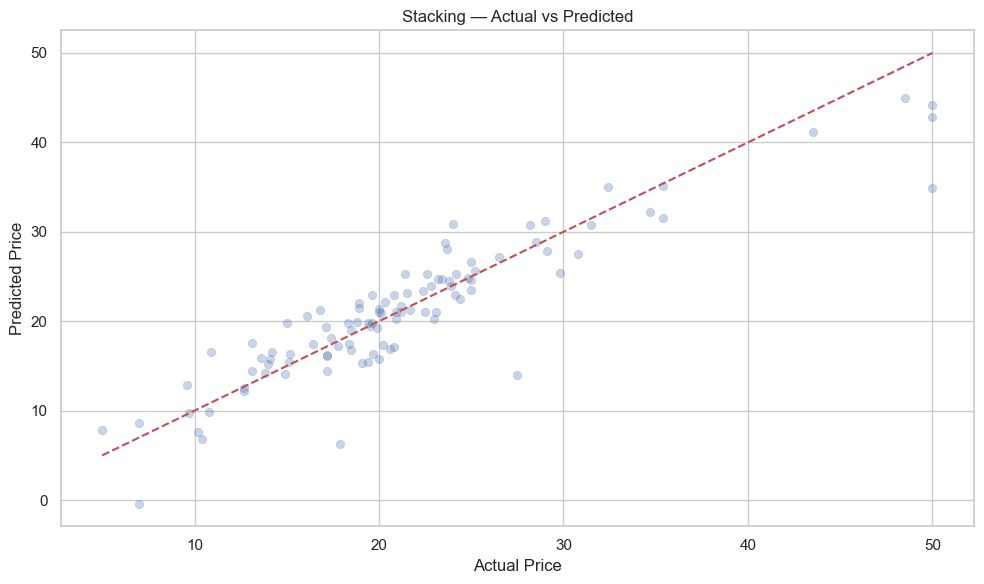

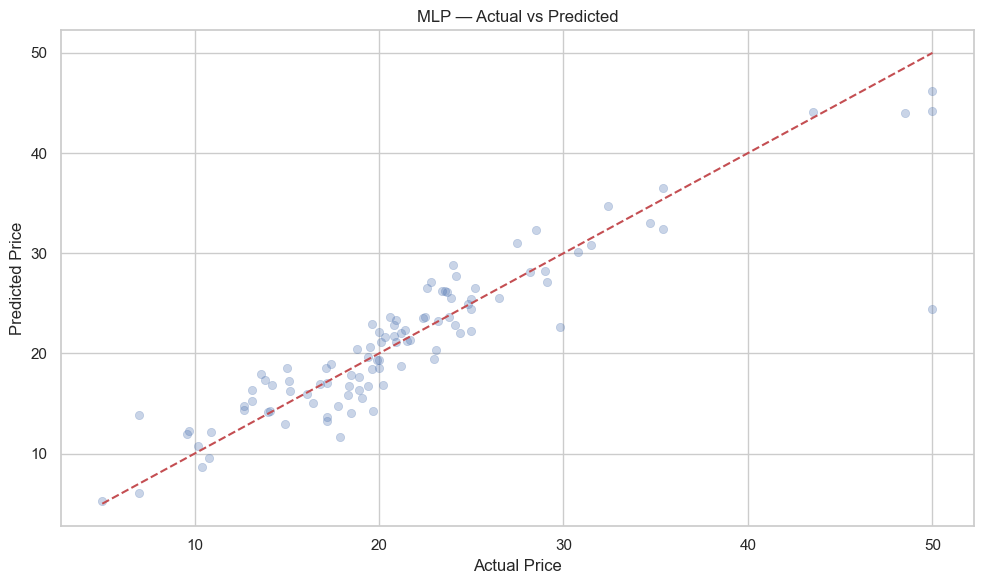

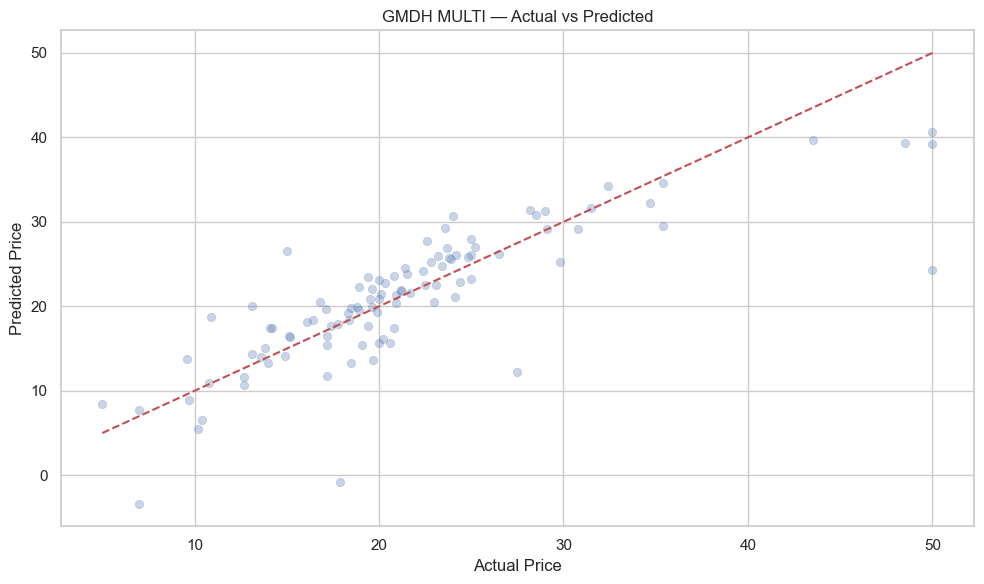

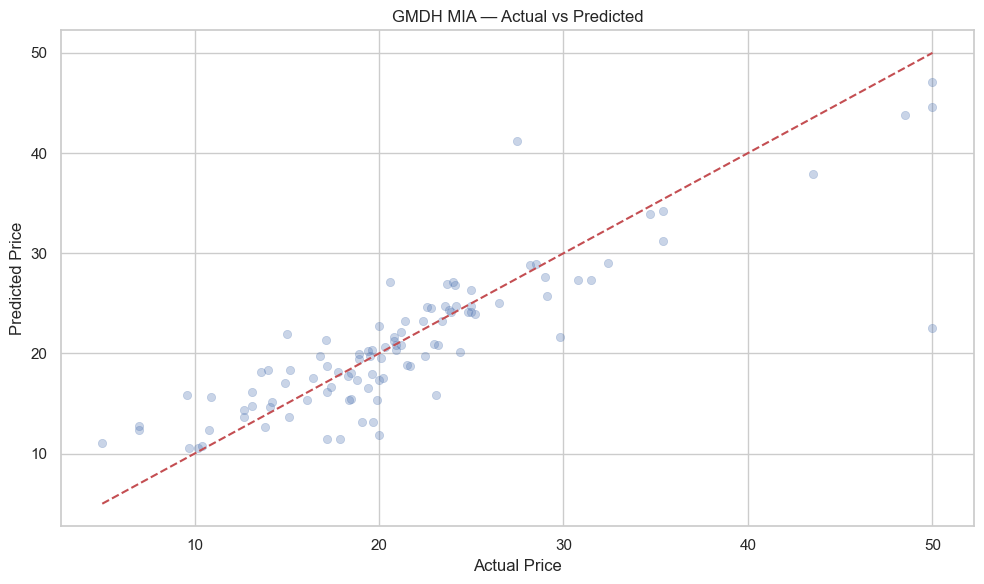

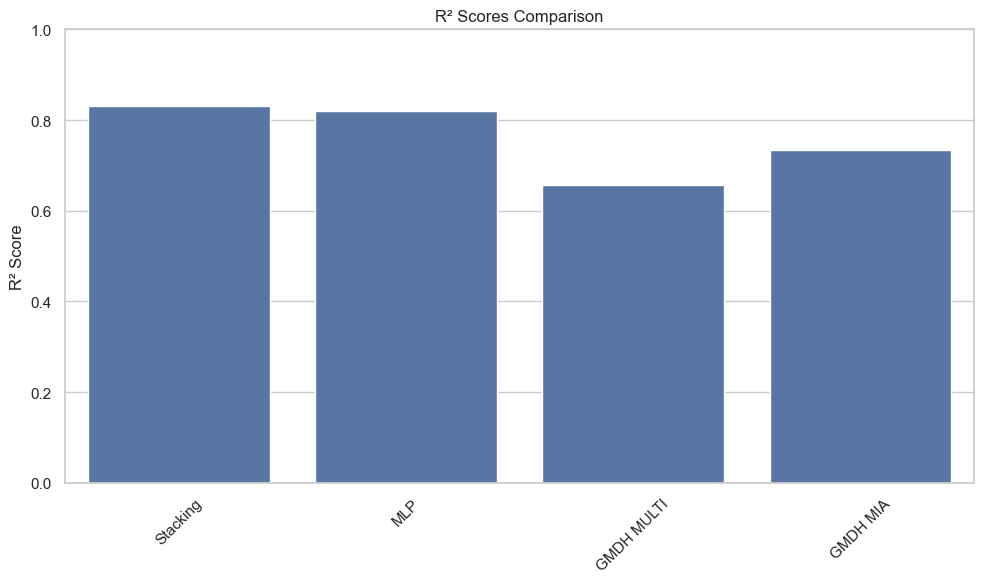

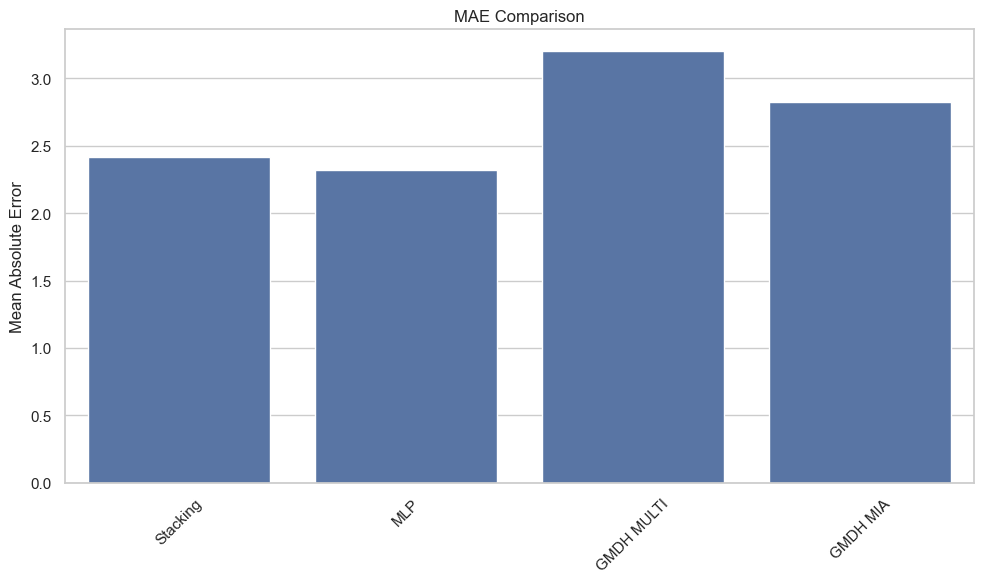

In [12]:
# Визуализация
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

models = {
    "Stacking": y_pred_stacking,
    "MLP": y_pred_mlp,
    "GMDH MULTI": y_pred_multi,
    "GMDH MIA": y_pred_mia
}

# 1. Фактические vs Предсказанные значения
for name, preds in models.items():
    plt.figure()
    sns.scatterplot(x=y_test, y=preds, alpha=0.3, edgecolor=None)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title(f"{name} — Actual vs Predicted")
    plt.xlabel("Actual Price")
    plt.ylabel("Predicted Price")
    plt.tight_layout()
    plt.show()

# 2. Сравнение R² и MAE
r2_scores = {name: r2_score(y_test, pred) for name, pred in models.items()}
mae_scores = {name: mean_absolute_error(y_test, pred) for name, pred in models.items()}

plt.figure()
sns.barplot(x=list(r2_scores.keys()), y=list(r2_scores.values()))
plt.title("R² Scores Comparison")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure()
sns.barplot(x=list(mae_scores.keys()), y=list(mae_scores.values()))
plt.title("MAE Comparison")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()